In [81]:
import tensorflow as tf
import tensorflow_datasets as tfds
# from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, Activation, Rescaling
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential as SequentialModel
# import keras_tuner as kt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

import os
import time

from pathlib import Path

# tf.random.set_seed(5263)
tf.__version__

'2.14.0'

In [82]:
# Set up datasets before passing to the model


# TODO: Image shape should be taken from the dataset, not hardcoded
image_shape = (400, 400, 3)

# Normalise image values to 0-1 from 0-255
img_normaliser = layers.Rescaling(1./255)

In [83]:
incomplete_dataset_path = Path("") / "datasets" / "data" / "TEST-okinimesumama-expert-24-played-incomplete"

df = pd.read_csv(incomplete_dataset_path / "labels.csv")

df.head()

,file_name,b1,b2,b3,b4,b5,b6,b7,b8
0,okinimesumama-expert-24-played-incomplete-0000...,False,False,False,False,False,False,False,False
1,okinimesumama-expert-24-played-incomplete-0000...,False,False,False,False,False,False,False,False
2,okinimesumama-expert-24-played-incomplete-0000...,False,False,False,False,False,False,False,False
3,okinimesumama-expert-24-played-incomplete-0000...,False,False,False,False,False,False,False,False
4,okinimesumama-expert-24-played-incomplete-0000...,False,False,False,False,False,False,False,False


In [84]:
file_names = df["file_name"].values
for count, i in enumerate(file_names):
    file_names[count] = str(incomplete_dataset_path / i)
file_names[:100]  # Truncated to stop the notebook from becoming huge

array(['datasets\\data\\TEST-okinimesumama-expert-24-played-incomplete\\okinimesumama-expert-24-played-incomplete-0000000000.png',
       'datasets\\data\\TEST-okinimesumama-expert-24-played-incomplete\\okinimesumama-expert-24-played-incomplete-0000000001.png',
       'datasets\\data\\TEST-okinimesumama-expert-24-played-incomplete\\okinimesumama-expert-24-played-incomplete-0000000002.png',
       'datasets\\data\\TEST-okinimesumama-expert-24-played-incomplete\\okinimesumama-expert-24-played-incomplete-0000000003.png',
       'datasets\\data\\TEST-okinimesumama-expert-24-played-incomplete\\okinimesumama-expert-24-played-incomplete-0000000004.png',
       'datasets\\data\\TEST-okinimesumama-expert-24-played-incomplete\\okinimesumama-expert-24-played-incomplete-0000000005.png',
       'datasets\\data\\TEST-okinimesumama-expert-24-played-incomplete\\okinimesumama-expert-24-played-incomplete-0000000006.png',
       'datasets\\data\\TEST-okinimesumama-expert-24-played-incomplete\\okinimesuma

In [85]:
# Make a copy for labels in case we need everything together later - `df` is intact
labels = df.drop("file_name", axis=1)
labels.head()

,b1,b2,b3,b4,b5,b6,b7,b8
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False


In [86]:
# Ensure format of labels is correct
dataset_train = tf.data.Dataset.from_tensor_slices((file_names, labels))
dataset_train

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(8,), dtype=tf.bool, name=None))>

In [87]:
label_list = list(labels.to_numpy())
for count, label in enumerate(label_list):
    label_list[count] = tuple(label)

label_list

[(False, False, False, False, False, False, False, False),
 (False, False, False, False, False, False, False, False),
 (False, False, False, False, False, False, False, False),
 (False, False, False, False, False, False, False, False),
 (False, False, False, False, False, False, False, False),
 (False, False, False, False, False, False, False, False),
 (False, False, False, False, False, False, False, False),
 (False, False, False, False, False, False, False, False),
 (False, False, False, False, False, False, False, False),
 (False, False, False, False, False, False, False, False),
 (False, False, False, False, False, False, False, False),
 (False, False, False, False, False, False, False, False),
 (False, False, False, False, False, False, False, False),
 (False, False, False, False, False, False, False, False),
 (False, False, False, False, False, False, False, False),
 (False, False, False, False, False, False, False, False),
 (False, False, False, False, False, False, False, False

In [88]:
string_base_path = str(incomplete_dataset_path)
def read_image(image_path, labels):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = img_normaliser(image)
    # `decode_png` does not state the size of the image, so we force it here`
    image.set_shape([400, 400, 3])
    # In a normal dataset, the first dimension states how many samples are in the set. 
    # Since teach tensor set here represents 1 sample, we insert a new dimension (which will have length 1) 
    # to state that there is 1 sample
    image = tf.expand_dims(image, 0)
    labels = [labels]
    
    return image, labels

dataset_train = dataset_train.map(read_image)
dataset_train

<_MapDataset element_spec=(TensorSpec(shape=(1, 400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, 8), dtype=tf.bool, name=None))>

In [89]:
# # TODO: Look into moving labels to directory structure instead of csv file, then infer labels via keras
# keras_dataset = tf.keras.utils.image_dataset_from_directory(
#     str(incomplete_dataset_path),
#     label_list,
#     label_mode="categorical",
#     image_size=(400, 400)
# )
# keras_dataset

In [90]:
# dataset_path = Path("") / "datasets" / "data" / "TEST-okinimesumama-expert-24-played-incomplete_ordered_1699049249.49"
# 
# folder_name = "b1_b2_b3_b4"
# image_path = dataset_path / folder_name
# print(image_path)
# 
# img_path = image_path / os.listdir(image_path)[0]
# img = tf.image.decode_png(tf.io.read_file(str(img_path)))
# label_list = img_path.parts[-2]
# label_list
# labels = label_list.split("_")
# 
# label_arr = ["b1" in labels, "b2" in labels, "b3" in labels, "b4" in labels, 
#              "b5" in labels, "b6" in labels, "b7" in labels, "b8" in labels]
# label_arr

In [91]:
# def load_image(image_name, image_labels):
#     # print(image_name)
#     image_path = "datassets/data/TEST-okinimesumama-expert-24-played-incomplete/" + image_name
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_png(image)
#     # print(image.)
#     rescaler = layers.Rescaling(1./255)
#     rescaled_image = rescaler(image)
#     return image, image_labels
# 
# def augment_image(image, image_labels):
#     # TODO: Add applicable augmentation (brightness, saturation?, slight scaling?)
#     return image, image_labels
# 
# # The top line of the image is all black due to the screen outputting a circle for the play area, so the output here is not alarming (use indexing to select a specific pixel to prove that the file is correctly read)
# # load_image(file_names[0], labels.head(1))
# 
# dataset_train = dataset_train.map(load_image)
# dataset_train[0]

In [92]:
wamai_model = SequentialModel([
    
    # layers.InputLayer(input_shape=(400, 400, 3)),
    layers.Conv2D(filters = 32, kernel_size = (3,3), strides = 2, input_shape = image_shape),
    layers.Activation('relu'),
    layers.BatchNormalization(),

    layers.Conv2D(filters = 64, kernel_size = (3,3), strides = 2),
    layers.Activation('relu'),
    layers.BatchNormalization(),

    layers.Conv2D(filters = 128, kernel_size = (3,3), strides = 2),
    layers.Activation('relu'),
    layers.BatchNormalization(),

    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Conv2D(filters = 32, kernel_size = (3,3)),
    layers.Activation('relu'),
    layers.BatchNormalization(),

    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Flatten(),

    layers.Dense(units = 512),
    layers.Activation('relu'),

    layers.Dense(units = 512),
    layers.Activation('relu'),

    layers.Dense(units = 8),
    layers.Activation('sigmoid')

])

wamai_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 199, 199, 32)      896       
                                                                 
 activation_35 (Activation)  (None, 199, 199, 32)      0         
                                                                 
 batch_normalization_20 (Ba  (None, 199, 199, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_21 (Conv2D)          (None, 99, 99, 64)        18496     
                                                                 
 activation_36 (Activation)  (None, 99, 99, 64)        0         
                                                                 
 batch_normalization_21 (Ba  (None, 99, 99, 64)        256       
 tchNormalization)                                    

In [93]:
wamai_model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='binary_crossentropy',  # Binary crossentropy predicts a probability for each label - much more like the outputs wanted
                    # Try sigmoid_crossentropy if binary fails
                    metrics=["accuracy"])

In [94]:
model_file_path = Path("") / "models" / "WA.M.AI proto 1" / f"WA.M.AI-p-1_binary_high-epoch{time.time()}.ckpt"
model_file_path_string = str(model_file_path)
model_folder = model_file_path.parent
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

checkpoint_filepath = model_file_path.parent / "WA.M.AI-p-binary-sigmoid-epoch{epoch:02d}-l{loss:.2f}-acc{accuracy:.4f}.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

wamai_model.fit(dataset_train, epochs=50, callbacks=[model_checkpoint_callback])

# wamai_model.save_weights(model_file_path_string)

Epoch 1/50
2260/2260 [==============================] - 163s 71ms/step - loss: 0.5969 - accuracy: 0.1664
Epoch 2/50
2260/2260 [==============================] - 160s 71ms/step - loss: 0.5518 - accuracy: 0.1363
Epoch 3/50
2260/2260 [==============================] - 165s 73ms/step - loss: 0.5646 - accuracy: 0.1841
Epoch 4/50
2260/2260 [==============================] - 163s 72ms/step - loss: 0.5306 - accuracy: 0.1518
Epoch 5/50
2260/2260 [==============================] - 161s 71ms/step - loss: 0.5256 - accuracy: 0.1416
Epoch 6/50
2260/2260 [==============================] - 161s 71ms/step - loss: 0.4140 - accuracy: 0.2757
Epoch 7/50
2260/2260 [==============================] - 161s 71ms/step - loss: 0.3913 - accuracy: 0.2978
Epoch 8/50
2260/2260 [==============================] - 161s 71ms/step - loss: 0.3747 - accuracy: 0.2942
Epoch 9/50
2260/2260 [==============================] - 163s 72ms/step - loss: 0.3776 - accuracy: 0.3053
Epoch 10/50
2260/2260 [==============================] 

In [95]:
dataset_test = tf.data.Dataset.from_tensor_slices((["datasets\\data\\TEST-okinimesumama-expert-24-played-incomplete\\okinimesumama-expert-24-played-incomplete-0000001266.png", "datasets\\data\\TEST-okinimesumama-expert-24-played-incomplete\\okinimesumama-expert-24-played-incomplete-0000001858.png"], [[False,True,True,False,False,False,True,True], [False,False,False,False,True,False,True,True]]))
# dataset_test
dataset_test = dataset_test.map(read_image)
dataset_test

<_MapDataset element_spec=(TensorSpec(shape=(1, 400, 400, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1, 8), dtype=tf.bool, name=None))>

In [96]:
# TODO: Modify toolkit to make template label file contain every frame, and edit the labels as they are submitted.
preds = wamai_model.predict(dataset_test)
preds

2/2 [==============================] - 0s 15ms/step


array([[9.0413354e-19, 5.9896773e-03, 9.9999905e-01, 5.2961409e-27,
        1.5700649e-18, 3.4062652e-30, 9.9998099e-01, 1.0000000e+00],
       [1.2258252e-28, 3.2675497e-22, 1.0726365e-34, 3.5342965e-26,
        1.0000000e+00, 1.6043440e-27, 1.0000000e+00, 1.0000000e+00]],
      dtype=float32)

In [99]:
# Only predicting 1 category/total certainty of 1 - we want a model to predict multiple classes
# Changing activation to sigmoid to make predictions independant of one another
preds[0].sum()

3.0059695

In [100]:
wamai_model_loaded = SequentialModel([
    
    # layers.InputLayer(input_shape=(400, 400, 3)),
    layers.Conv2D(filters = 32, kernel_size = (3,3), strides = 2, input_shape = image_shape),
    layers.Activation('relu'),
    layers.BatchNormalization(),

    layers.Conv2D(filters = 64, kernel_size = (3,3), strides = 2),
    layers.Activation('relu'),
    layers.BatchNormalization(),

    layers.Conv2D(filters = 128, kernel_size = (3,3), strides = 2),
    layers.Activation('relu'),
    layers.BatchNormalization(),

    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Conv2D(filters = 32, kernel_size = (3,3)),
    layers.Activation('relu'),
    layers.BatchNormalization(),

    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Flatten(),

    layers.Dense(units = 512),
    layers.Activation('relu'),

    layers.Dense(units = 512),
    layers.Activation('relu'),

    layers.Dense(units = 8),
    layers.Activation('sigmoid')

])

model_to_load = model_folder / "WA.M.AI-p-binary-sigmoid-epoch40-l0.04-acc0.4770.hdf5"

wamai_model_loaded.load_weights(model_to_load)

In [104]:
loaded_model_preds = wamai_model_loaded.predict(dataset_test)
loaded_model_preds

2/2 [==============================] - 0s 25ms/step


array([[5.64018166e-10, 7.10181561e-14, 1.00000000e+00, 1.25387431e-15,
        1.29795607e-17, 3.80265982e-23, 5.85248014e-21, 7.96277050e-07],
       [3.23510685e-09, 1.62321712e-10, 2.45446563e-19, 1.12048077e-08,
        1.00000000e+00, 1.13825054e-10, 1.00000000e+00, 1.00000000e+00]],
      dtype=float32)

In [111]:
preds[0].sum()

pred_true = []

for i in preds[1]:
    pred_true.append(i > 0.5)
    
pred_true

[False, False, False, False, True, False, True, True]

In [107]:
wamai_model_loaded.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 199, 199, 32)      896       
                                                                 
 activation_42 (Activation)  (None, 199, 199, 32)      0         
                                                                 
 batch_normalization_24 (Ba  (None, 199, 199, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_25 (Conv2D)          (None, 99, 99, 64)        18496     
                                                                 
 activation_43 (Activation)  (None, 99, 99, 64)        0         
                                                                 
 batch_normalization_25 (Ba  (None, 99, 99, 64)        256       
 tchNormalization)                                    

1/1 [==============================] - 0s 292ms/step


C:\Users\Zestyy\AppData\Local\Temp\ipykernel_24224\1410238932.py:31: RuntimeWarning: divide by zero encountered in divide
  img = ((((img - img.mean()) / img.std()) * 64) + 128)
C:\Users\Zestyy\AppData\Local\Temp\ipykernel_24224\1410238932.py:31: RuntimeWarning: invalid value encountered in divide
  img = ((((img - img.mean()) / img.std()) * 64) + 128)
C:\Users\Zestyy\AppData\Local\Temp\ipykernel_24224\1410238932.py:32: RuntimeWarning: invalid value encountered in cast
  img = np.clip(img, 0, 255).astype('uint8')


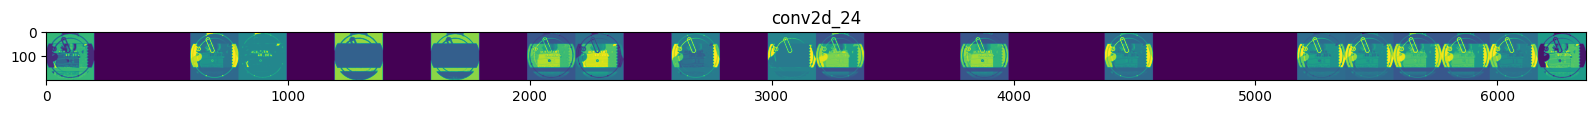

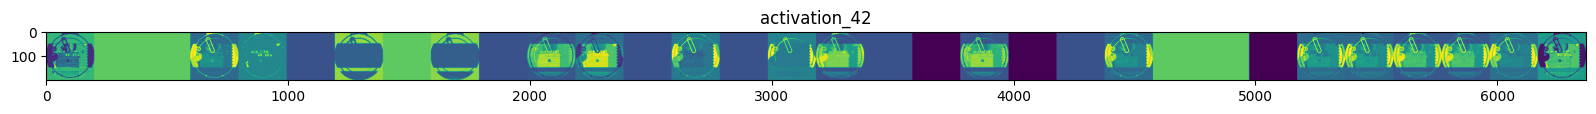

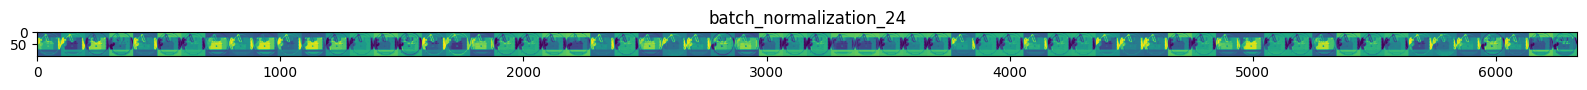

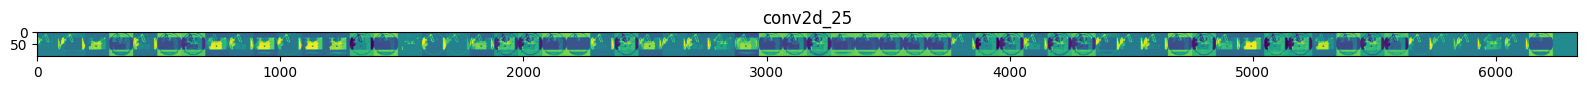

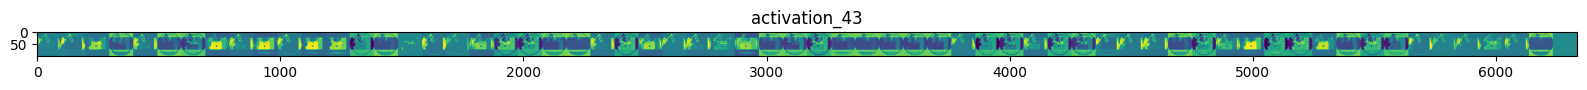

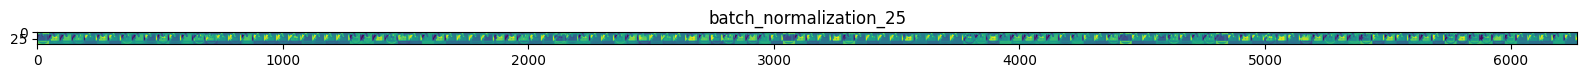

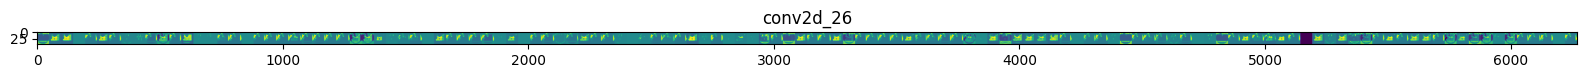

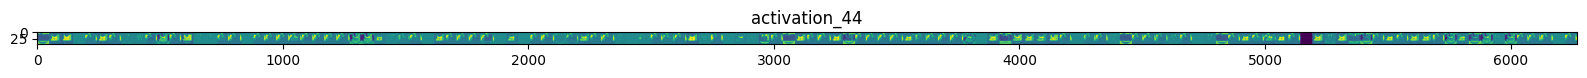

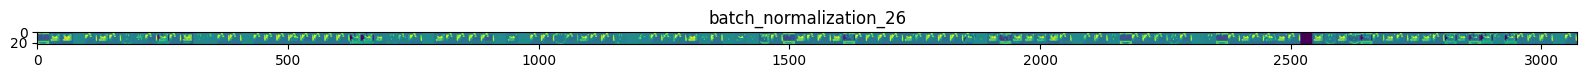

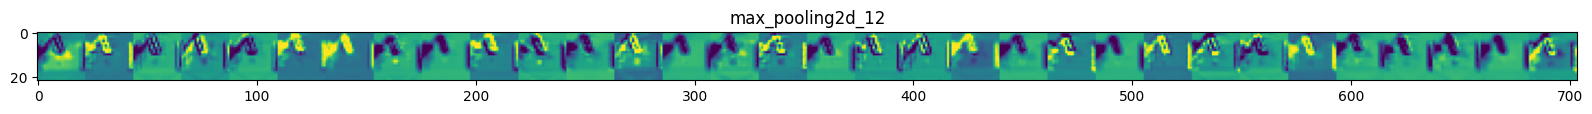

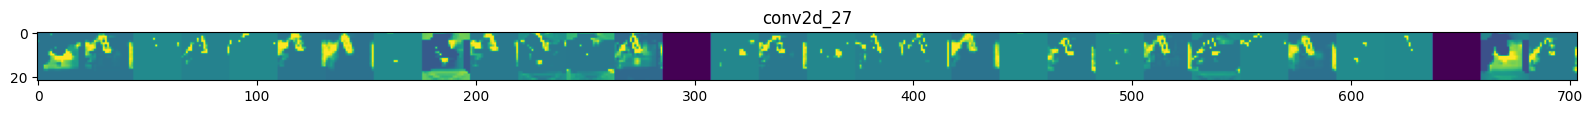

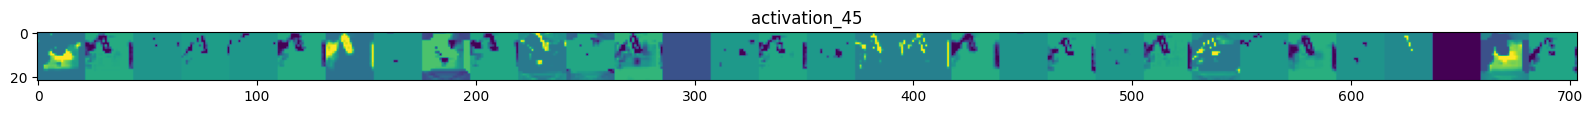

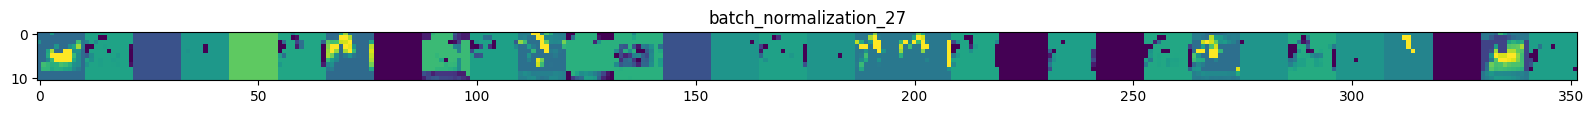

In [106]:

layer_outputs = []

dataset_test = tf.data.Dataset.from_tensor_slices((["datasets\\data\\TEST-okinimesumama-expert-24-played-incomplete\\okinimesumama-expert-24-played-incomplete-0000001858.png"], [[False,False,False,False,True,False,True,True]]))
# dataset_test
dataset_test = dataset_test.map(read_image)

for layer in wamai_model_loaded.layers[1:]:
    layer_outputs.append(layer.output)

layer_names = []

for layer in wamai_model_loaded.layers:
    layer_names.append(layer.name)
features_model = tf.keras.models.Model(inputs = wamai_model_loaded.input, outputs = layer_outputs)

random_sample = dataset_test.take(1)
layer_predictions = features_model.predict(random_sample)

for layer_name, prediction in zip(layer_names, layer_predictions):
    if len(prediction.shape) != 4:
        continue

    num_features = prediction.shape[-1]
    size = prediction.shape[1]
    grid = np.zeros((size, size * num_features))

    for i in range(num_features):
        img = prediction[0, :, :, i]
        img = ((((img - img.mean()) / img.std()) * 64) + 128)
        img = np.clip(img, 0, 255).astype('uint8')
        grid[:, i * size : (i + 1) * size] = img

    scale = 20. / num_features
    plt.figure(figsize=(scale * num_features, scale))
    plt.title(layer_name)
    plt.imshow(grid)

In [108]:
wamai_model_loaded.save(model_folder / "WA.M.AI prototype 1.keras")